# CH04_2_Timeseries Simulation using Code

- last update : 2022.05.10.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# Data construction by yourself

## member status 
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']

## data generation using differen generating probability for each class 
## by controlling p value from np.random.choice
memberYears = np.random.choice(years, 1000, p = [0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000, p = [0.5, 0.3, 0.1, 0.1])
yearJoined = pd.DataFrame({'yearJoined': memberYears, 
                           'memberStats': memberStats})

yearJoined

,yearJoined,memberStats
0,2017,bronze
1,2016,gold
2,2017,bronze
3,2018,bronze
4,2018,bronze
...,...,...
995,2018,inactive
996,2018,bronze
997,2018,bronze
998,2018,gold


In [3]:
yearJoined.value_counts()

yearJoined  memberStats
2018        bronze         164
2017        bronze         148
2018        silver         115
2016        bronze          87
2017        silver          85
2015        bronze          52
2014        bronze          51
2016        silver          44
2018        inactive        40
            gold            39
2017        inactive        37
            gold            30
2014        silver          27
2015        silver          26
2016        gold            17
2015        gold            10
2016        inactive        10
2015        inactive         9
2014        gold             5
            inactive         4
dtype: int64

In [4]:
# data construction process based on the newly established hypothesis by experts 
# considering unobservable process 

NUM_EMAILS_SENT_WEEKLY = 3 

## Defining some functions for different patterns among data
def never_opens(period_rng): 
    return []

def constant_open_rate(period_rng): 
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened  

def increasing_open_rate(period_rng): 
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac): 
    if len(period_rng) < 1: 
        return []
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng), 2): 
        try: 
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
            num_opened[prd:(prd + 2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p * fac), 0)
        except: 
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)): 
        num_opened[times[t]] = 0 
    return num_opened

In [5]:
## Donation activity conncted with mail openning actions

def produce_donations(period_rng, member_behavior, num_emails, 
                      use_id, member_join_year): 
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY *len(period_rng))
    member_gives = member_has * email_fraction 
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, 
                              len(donation_amounts)-2), 
                               1)
    num_times_gave = np.random.poisson(2) * (2018-member_join_year)
    print (">>> num_times_gave =\n", num_times_gave)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member' : [],
                         'amount' : [],
                         'timestamp' : []})
    
    for n in range(num_times_gave): 
        donation = donation_amounts[member_gives_idx 
                                   +np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time
                           +random_weekly_time_delta())
        
        dons = dons.append(pd.DataFrame(
                    {'member' : [use_id], 
                     'amount' : [donation], 
                     'timestamp' : [ts]}))
        
        if dons.shape[0] > 0: 
            dons = dons[dons.amount != 0]
            ## Do not report if donation is zero.
            ## These information is not reflecting in the database. 
            
            return dons                    

In [6]:
# utility function to select specific time in day during week
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute =[s for s in range(60)]
    return  pd.Timedelta(str(np.random.choice(days_of_week))+" days") +\
            pd.Timedelta(str(np.random.choice(hours_of_day))+" hours") +\
            pd.Timedelta(str(np.random.choice(minute_of_hour))+" minutes") +\
            pd.Timedelta(str(np.random.choice(second_of_minute))+" seconds")        

In [7]:
## Collection of module to simulate specific member's event 

behaviors = [never_opens,
            constant_open_rate, 
            increasing_open_rate, 
            decreasing_open_rate]

member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])
rng = pd.period_range('2015-02-14', '2018-06-01', freq ='W')

emails= pd.DataFrame({'member': [],
                      'week': [],
                      'emailsOpened': []})
donations = pd.DataFrame({'member': [], 
                          'amount': [],
                          'tunestamp': []})

for idx in range(yearJoined.shape[0]): 
    ## Randomly create when member is registered. 
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) +\
                pd.Timedelta(str(np.random.randint(3, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
    
    print (join_date)
    print (rng)
    print (rng[2])
    ## Timestamps for specific behaviors should not be existed before registration 
    member_rng = rng[rng.to_timestamp(freq="D",how='start') > join_date]
    print (">>> member_rng =\n", member_rng)
    if len(member_rng) < 1: 
        continue
        
    info = member_behaviors[idx](member_rng)
    print (">>> info =", info)
    
    if len(info) ==  len(member_rng): 
        emails = emails.append(pd.DataFrame(
            {'member': [idx] * len(info), 
             'week' : [str(r) for r in member_rng], 
             'emailsOpened' : info}))
        print (">>> emails = \n", emails)
        print(">>> member_rng =", member_rng)
        print(">>> len(member_rng) =", len(member_rng))
        
        print(">>> member_behaviors[idx] =", member_behaviors[idx])
        print(">>> sum[info] =", sum(info))
        print(">>> idx=",idx)
        print(">>> join_date.year = ", join_date.year)
        print(produce_donations(member_rng, member_behaviors[idx], sum(info), idx, join_date.year))

        donations = donations.append(
            produce_donations(member_rng, member_behaviors[idx], 
                                 sum(info), idx, join_date.year))   

2017-07-23 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-07-24/2017-07-30', '2017-07-31/2017-08-06',
             '2017-08-07/2017-08-13', '2017-08-14/2017-08-20',
             '2017-08-21/2017-08-27', '2017-08-28/2017-09-03',
             '2017-09-04/2017-09-10', '2017-09-11/2017-0

2018-04-23 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2018-04-30/2018-05-06', '2018-05-07/2018-05-13',
             '2018-05-14/2018-05-20', '2018-05-21/2018-05-27',
             '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]')
>>> info = [0. 1. 2. 2. 2.]
>>> emails = 
   

            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2018-02-12/2018-02-18', '2018-02-19/2018-02-25',
             '2018-02-26/2018-03-04', '2018-03-05/2018-03-11',
             '2018-03-12/2018-03-18', '2018-03-19/2018-03-25',
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]')
>>> info = []
2016-06-13 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
       

0   106.0    50.0  2017-07-22 13:31:58
>>> num_times_gave =
 3
2017-10-07 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-10-09/2017-10-15', '2017-10-16/2017-10-22',
             '2017-10-23/2017-10-29', '2017-10-30/2017-11-05',
             '2017-11-06/2017-11-12', '2017-11-13/2017-1

2017-04-02 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-04-03/2017-04-09', '2017-04-10/2017-04-16',
             '2017-04-17/2017-04-23', '2017-04-24/2017-04-30',
             '2017-05-01/2017-05-07', '2017-05-08/2017-05-14',
             '2017-05-15/2017-05-21', '2017-05-22/2017-0

>>> emails = 
     member                   week  emailsOpened
0      0.0  2017-07-24/2017-07-30           0.0
1      0.0  2017-07-31/2017-08-06           0.0
2      0.0  2017-08-07/2017-08-13           0.0
3      0.0  2017-08-14/2017-08-20           0.0
4      0.0  2017-08-21/2017-08-27           0.0
..     ...                    ...           ...
48   181.0  2018-04-30/2018-05-06           0.0
49   181.0  2018-05-07/2018-05-13           1.0
50   181.0  2018-05-14/2018-05-20           2.0
51   181.0  2018-05-21/2018-05-27           0.0
52   181.0  2018-05-28/2018-06-03           0.0

[7678 rows x 3 columns]
>>> member_rng = PeriodIndex(['2017-05-29/2017-06-04', '2017-06-05/2017-06-11',
             '2017-06-12/2017-06-18', '2017-06-19/2017-06-25',
             '2017-06-26/2017-07-02', '2017-07-03/2017-07-09',
             '2017-07-10/2017-07-16', '2017-07-17/2017-07-23',
             '2017-07-24/2017-07-30', '2017-07-31/2017-08-06',
             '2017-08-07/2017-08-13', '2017-08-14/20

2015-05-31 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2015-06-01/2015-06-07', '2015-06-08/2015-06-14',
             '2015-06-15/2015-06-21', '2015-06-22/2015-06-28',
             '2015-06-29/2015-07-05', '2015-07-06/2015-07-12',
             '2015-07-13/2015-07-19', '2015-07-20/2015-0

   member  amount            timestamp
0   247.0    25.0  2016-06-25 22:51:59
>>> num_times_gave =
 0
2017-02-25 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-02-27/2017-03-05', '2017-03-06/2017-03-12',
             '2017-03-13/2017-03-19', '2017-03-20/2017-03-26',
             '201

2018-02-13 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2018-02-19/2018-02-25', '2018-02-26/2018-03-04',
             '2018-03-05/2018-03-11', '2018-03-12/2018-03-18',
             '2018-03-19/2018-03-25', '2018-03-26/2018-04-01',
             '2018-04-02/2018-04-08', '2018-04-09/2018-0

 PeriodIndex(['2017-06-12/2017-06-18', '2017-06-19/2017-06-25',
             '2017-06-26/2017-07-02', '2017-07-03/2017-07-09',
             '2017-07-10/2017-07-16', '2017-07-17/2017-07-23',
             '2017-07-24/2017-07-30', '2017-07-31/2017-08-06',
             '2017-08-07/2017-08-13', '2017-08-14/2017-08-20',
             '2017-08-21/2017-08-27', '2017-08-28/2017-09-03',
             '2017-09-04/2017-09-10', '2017-09-11/2017-09-17',
             '2017-09-18/2017-09-24', '2017-09-25/2017-10-01',
             '2017-10-02/2017-10-08', '2017-10-09/2017-10-15',
             '2017-10-16/2017-10-22', '2017-10-23/2017-10-29',
             '2017-10-30/2017-11-05', '2017-11-06/2017-11-12',
             '2017-11-13/2017-11-19', '2017-11-20/2017-11-26',
             '2017-11-27/2017-12-03', '2017-12-04/2017-12-10',
             '2017-12-11/2017-12-17', '2017-12-18/2017-12-24',
             '2017-12-25/2017-12-31', '2018-01-01/2018-01-07',
             '2018-01-08/2018-01-14', '2018-01-15/2018

2017-10-28 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-10-30/2017-11-05', '2017-11-06/2017-11-12',
             '2017-11-13/2017-11-19', '2017-11-20/2017-11-26',
             '2017-11-27/2017-12-03', '2017-12-04/2017-12-10',
             '2017-12-11/2017-12-17', '2017-12-18/2017-1

0   388.0   250.0  2018-03-21 14:15:53
>>> num_times_gave =
 16
2015-09-15 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2015-09-21/2015-09-27', '2015-09-28/2015-10-04',
             '2015-10-05/2015-10-11', '2015-10-12/2015-10-18',
             '2015-10-19/2015-10-25', '2015-10-26/2015-

[18521 rows x 3 columns]
>>> member_rng = PeriodIndex(['2016-12-26/2017-01-01', '2017-01-02/2017-01-08',
             '2017-01-09/2017-01-15', '2017-01-16/2017-01-22',
             '2017-01-23/2017-01-29', '2017-01-30/2017-02-05',
             '2017-02-06/2017-02-12', '2017-02-13/2017-02-19',
             '2017-02-20/2017-02-26', '2017-02-27/2017-03-05',
             '2017-03-06/2017-03-12', '2017-03-13/2017-03-19',
             '2017-03-20/2017-03-26', '2017-03-27/2017-04-02',
             '2017-04-03/2017-04-09', '2017-04-10/2017-04-16',
             '2017-04-17/2017-04-23', '2017-04-24/2017-04-30',
             '2017-05-01/2017-05-07', '2017-05-08/2017-05-14',
             '2017-05-15/2017-05-21', '2017-05-22/2017-05-28',
             '2017-05-29/2017-06-04', '2017-06-05/2017-06-11',
             '2017-06-12/2017-06-18', '2017-06-19/2017-06-25',
             '2017-06-26/2017-07-02', '2017-07-03/2017-07-09',
             '2017-07-10/2017-07-16', '2017-07-17/2017-07-23',
             

0   458.0   100.0  2017-05-09 22:57:47
>>> num_times_gave =
 2
2015-05-04 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2015-05-11/2015-05-17', '2015-05-18/2015-05-24',
             '2015-05-25/2015-05-31', '2015-06-01/2015-06-07',
             '2015-06-08/2015-06-14', '2015-06-15/2015-0

2018-06-01 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex([], dtype='period[W-SUN]')
2016-09-02 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22

>>> emails = 
      member                   week  emailsOpened
0       0.0  2017-07-24/2017-07-30           0.0
1       0.0  2017-07-31/2017-08-06           0.0
2       0.0  2017-08-07/2017-08-13           0.0
3       0.0  2017-08-14/2017-08-20           0.0
4       0.0  2017-08-21/2017-08-27           0.0
..      ...                    ...           ...
132   529.0  2018-04-30/2018-05-06           1.0
133   529.0  2018-05-07/2018-05-13           0.0
134   529.0  2018-05-14/2018-05-20           0.0
135   529.0  2018-05-21/2018-05-27           2.0
136   529.0  2018-05-28/2018-06-03           3.0

[23589 rows x 3 columns]
>>> member_rng = PeriodIndex(['2015-10-19/2015-10-25', '2015-10-26/2015-11-01',
             '2015-11-02/2015-11-08', '2015-11-09/2015-11-15',
             '2015-11-16/2015-11-22', '2015-11-23/2015-11-29',
             '2015-11-30/2015-12-06', '2015-12-07/2015-12-13',
             '2015-12-14/2015-12-20', '2015-12-21/2015-12-27',
             ...
             '2018-03-

>>> sum[info] = 61.0
>>> idx= 563
>>> join_date.year =  2017
>>> num_times_gave =
 2
   member  amount            timestamp
0   563.0  1000.0  2017-12-08 14:09:49
>>> num_times_gave =
 0
2017-11-13 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-11-20/2017-11-26', '2017-11-27/2017-12-

>>> emails = 
     member                   week  emailsOpened
0      0.0  2017-07-24/2017-07-30           0.0
1      0.0  2017-07-31/2017-08-06           0.0
2      0.0  2017-08-07/2017-08-13           0.0
3      0.0  2017-08-14/2017-08-20           0.0
4      0.0  2017-08-21/2017-08-27           0.0
..     ...                    ...           ...
25   604.0  2018-05-28/2018-06-03           3.0
0    606.0  2018-05-07/2018-05-13           3.0
1    606.0  2018-05-14/2018-05-20           1.0
2    606.0  2018-05-21/2018-05-27           3.0
3    606.0  2018-05-28/2018-06-03           3.0

[26193 rows x 3 columns]
>>> member_rng = PeriodIndex(['2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]')
>>> len(member_rng) = 4
>>> member_behaviors[idx] = <function constant_open_rate at 0x000001C847EEEEE0>
>>> sum[info] = 10
>>> idx= 606
>>> join_date.year =  2018
>>> num_times_gave =
 0
None
>>> num_time

2018-06-01 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex([], dtype='period[W-SUN]')
2018-01-17 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22

0   668.0    50.0  2017-12-18 22:27:49
>>> num_times_gave =
 4
2016-02-10 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2016-02-15/2016-02-21', '2016-02-22/2016-02-28',
             '2016-02-29/2016-03-06', '2016-03-07/2016-03-13',
             '2016-03-14/2016-03-20', '2016-03-21/2016-0

 PeriodIndex(['2017-06-26/2017-07-02', '2017-07-03/2017-07-09',
             '2017-07-10/2017-07-16', '2017-07-17/2017-07-23',
             '2017-07-24/2017-07-30', '2017-07-31/2017-08-06',
             '2017-08-07/2017-08-13', '2017-08-14/2017-08-20',
             '2017-08-21/2017-08-27', '2017-08-28/2017-09-03',
             '2017-09-04/2017-09-10', '2017-09-11/2017-09-17',
             '2017-09-18/2017-09-24', '2017-09-25/2017-10-01',
             '2017-10-02/2017-10-08', '2017-10-09/2017-10-15',
             '2017-10-16/2017-10-22', '2017-10-23/2017-10-29',
             '2017-10-30/2017-11-05', '2017-11-06/2017-11-12',
             '2017-11-13/2017-11-19', '2017-11-20/2017-11-26',
             '2017-11-27/2017-12-03', '2017-12-04/2017-12-10',
             '2017-12-11/2017-12-17', '2017-12-18/2017-12-24',
             '2017-12-25/2017-12-31', '2018-01-01/2018-01-07',
             '2018-01-08/2018-01-14', '2018-01-15/2018-01-21',
             '2018-01-22/2018-01-28', '2018-01-29/2018

>>> member_rng = PeriodIndex(['2018-03-05/2018-03-11', '2018-03-12/2018-03-18',
             '2018-03-19/2018-03-25', '2018-03-26/2018-04-01',
             '2018-04-02/2018-04-08', '2018-04-09/2018-04-15',
             '2018-04-16/2018-04-22', '2018-04-23/2018-04-29',
             '2018-04-30/2018-05-06', '2018-05-07/2018-05-13',
             '2018-05-14/2018-05-20', '2018-05-21/2018-05-27',
             '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]')
>>> len(member_rng) = 13
>>> member_behaviors[idx] = <function decreasing_open_rate at 0x000001C847F191F0>
>>> sum[info] = 16.0
>>> idx= 727
>>> join_date.year =  2018
>>> num_times_gave =
 0
None
>>> num_times_gave =
 0
2018-06-01 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', 

0   770.0    25.0  2017-12-13 22:45:33
>>> num_times_gave =
 1
2017-09-14 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-09-18/2017-09-24', '2017-09-25/2017-10-01',
             '2017-10-02/2017-10-08', '2017-10-09/2017-10-15',
             '2017-10-16/2017-10-22', '2017-10-23/2017-1

 8
   member  amount            timestamp
0   806.0   250.0  2018-03-31 19:38:45
>>> num_times_gave =
 12
2014-04-19 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             

0   835.0   500.0  2017-12-09 20:23:42
>>> num_times_gave =
 0
2017-03-24 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-03-27/2017-04-02', '2017-04-03/2017-04-09',
             '2017-04-10/2017-04-16', '2017-04-17/2017-04-23',
             '2017-04-24/2017-04-30', '2017-05-01/2017-0

            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2016-05-09/2016-05-15', '2016-05-16/2016-05-22',
             '2016-05-23/2016-05-29', '2016-05-30/2016-06-05',
             '2016-06-06/2016-06-12', '2016-06-13/2016-06-19',
             '2016-06-20/2016-06-26', '2016-06-27/2016-07-03',
             '2016-07-04/2016-07-10', '2016-07-11/2016-07-17',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=108)
>>> info = [0 1 2 0 1 0 1 1 0 1 0 1 1 2 1 1 0 0 0 0 0 2 0 0 0 0 1 0 0 2 0 1 0 1 1 1 0
 1 1 0 0 1 0 0 1 1 2 0 1 0 0 1 0 1 2 1 0 0 0 1 2 0 0 1 1 2 1 0 1 1 0 0 0 1
 0 0 0 0 2 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 

>>> emails = 
     member                   week  emailsOpened
0      0.0  2017-07-24/2017-07-30           0.0
1      0.0  2017-07-31/2017-08-06           0.0
2      0.0  2017-08-07/2017-08-13           0.0
3      0.0  2017-08-14/2017-08-20           0.0
4      0.0  2017-08-21/2017-08-27           0.0
..     ...                    ...           ...
40   893.0  2018-04-30/2018-05-06           1.0
41   893.0  2018-05-07/2018-05-13           2.0
42   893.0  2018-05-14/2018-05-20           2.0
43   893.0  2018-05-21/2018-05-27           1.0
44   893.0  2018-05-28/2018-06-03           0.0

[40584 rows x 3 columns]
>>> member_rng = PeriodIndex(['2017-07-24/2017-07-30', '2017-07-31/2017-08-06',
             '2017-08-07/2017-08-13', '2017-08-14/2017-08-20',
             '2017-08-21/2017-08-27', '2017-08-28/2017-09-03',
             '2017-09-04/2017-09-10', '2017-09-11/2017-09-17',
             '2017-09-18/2017-09-24', '2017-09-25/2017-10-01',
             '2017-10-02/2017-10-08', '2017-10-09/2

2017-10-23 00:00:00
PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
2015-02-23/2015-03-01
>>> member_rng =
 PeriodIndex(['2017-10-30/2017-11-05', '2017-11-06/2017-11-12',
             '2017-11-13/2017-11-19', '2017-11-20/2017-11-26',
             '2017-11-27/2017-12-03', '2017-12-04/2017-12-10',
             '2017-12-11/2017-12-17', '2017-12-18/2017-1

>>> emails = 
      member                   week  emailsOpened
0       0.0  2017-07-24/2017-07-30           0.0
1       0.0  2017-07-31/2017-08-06           0.0
2       0.0  2017-08-07/2017-08-13           0.0
3       0.0  2017-08-14/2017-08-20           0.0
4       0.0  2017-08-21/2017-08-27           0.0
..      ...                    ...           ...
168   963.0  2018-04-30/2018-05-06           2.0
169   963.0  2018-05-07/2018-05-13           3.0
170   963.0  2018-05-14/2018-05-20           3.0
171   963.0  2018-05-21/2018-05-27           3.0
172   963.0  2018-05-28/2018-06-03           2.0

[43761 rows x 3 columns]
>>> member_rng = PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-

>>> emails = 
     member                   week  emailsOpened
0      0.0  2017-07-24/2017-07-30           0.0
1      0.0  2017-07-31/2017-08-06           0.0
2      0.0  2017-08-07/2017-08-13           0.0
3      0.0  2017-08-14/2017-08-20           0.0
4      0.0  2017-08-21/2017-08-27           0.0
..     ...                    ...           ...
61   994.0  2018-04-30/2018-05-06           1.0
62   994.0  2018-05-07/2018-05-13           1.0
63   994.0  2018-05-14/2018-05-20           1.0
64   994.0  2018-05-21/2018-05-27           1.0
65   994.0  2018-05-28/2018-06-03           2.0

[45451 rows x 3 columns]
>>> member_rng = PeriodIndex(['2017-02-27/2017-03-05', '2017-03-06/2017-03-12',
             '2017-03-13/2017-03-19', '2017-03-20/2017-03-26',
             '2017-03-27/2017-04-02', '2017-04-03/2017-04-09',
             '2017-04-10/2017-04-16', '2017-04-17/2017-04-23',
             '2017-04-24/2017-04-30', '2017-05-01/2017-05-07',
             '2017-05-08/2017-05-14', '2017-05-15/2

In [8]:
donations

,member,amount,tunestamp,timestamp
0,0.0,25.0,NaN,2018-01-15 14:22:35
0,1.0,100.0,NaN,2016-12-05 20:46:04
0,2.0,25.0,NaN,2018-01-15 15:50:16
0,5.0,500.0,NaN,2018-05-27 18:55:02
0,7.0,500.0,NaN,2018-02-17 18:32:49
...,...,...,...,...
0,985.0,500.0,NaN,2017-05-15 16:52:34
0,986.0,1000.0,NaN,2018-05-28 13:16:32
0,989.0,50.0,NaN,2018-04-01 17:10:53
0,991.0,25.0,NaN,2017-12-30 12:05:42


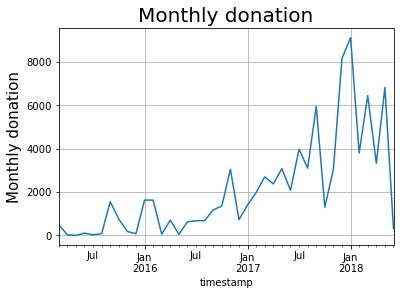

In [9]:
## Monthly donation plotting 

df = donations
df.set_index(pd.to_datetime(df.timestamp), inplace = True)
df.sort_index(inplace = True)
df.groupby(pd.Grouper(freq='M')).amount.sum().plot()
plt.ylabel('Monthly donation', fontsize =15)
plt.title ("Monthly donation", fontsize =20)

plt.grid()

## pd.period_range 와 pd.date_range간의 결과 비교 및 전환 

In [10]:
## pd.period_range 와 pd.date_range간의 결과 비교 및 전환 

rng = pd.period_range('2015-02-14', '2018-06-01', freq ='W')

print (">>> rng =\n", rng )

## 결과 전환 
print (">>> After conversion (start) =\n",rng.to_timestamp(freq="D",how='start'))
print ("\n>>> After conversion (end) =\n",rng.to_timestamp(freq="D",how='end'))

#pd.period_range?
#rng = pd.period_range(start = '2015-02-14', end = '2018-06-01', freq ='W')

rng_date_range = pd.date_range(start = '2015-02-14', end = '2018-06-01', freq ='W')
print ("\n>>> rng_date_range =\n", rng_date_range)

>>> rng =
 PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173)
>>> After conversion (start) =
 DatetimeIndex(['2015-02-09', '2015-02-16', '2015-02-23', '2015-03-02',
               '2015-03-09', '2015-03-16', '2015-03-23', '2015-03-30',
               '2015-04-06', '2015-04-13',
               ...
               '2018-03-26', '2018-04-02', '2018-04-09', '